In [1]:
%load_ext autoreload
%aimport venomseq

In [134]:
%pylab inline

from importlib import reload

import venomseq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.collections import LineCollection
import seaborn as sns
import os
import pandas as pd
from collections import Counter
import itertools
import scipy as sp
from sklearn.decomposition import PCA

sns.set(color_codes=True)

Populating the interactive namespace from numpy and matplotlib


In [10]:
plt.rc('text',usetex=True)

# `VenomSeq`: Visualization examples

This notebook shows several types of visualization that can be accomplished using the `venomseq` package.

- - -
### Load an existing VenomSeq analysis

Note: This uses local files that you will either need to obtain from the original authors (e.g., the GSE92742 data from GEO or clue.io) or generate yourself (e.g., the processed WCS and tau matrices that are generated using other subroutines in the `venomseq` Python package). For clarification or help, please submit an issue on the `jdromano2/venomseq` GitHub repository.

In [125]:
if os.name == 'nt':
  print("Running Windows example.")
  v = venomseq.VenomSeq(
    samples_file="test",
    gctx_file = "C:\\Users\\jdr2160\\venomseq_data\\annotated_GSE92742_Broad_LINCS_Level5_COMPZ_n473647x12328.gctx"
  )
  v.load(
    wcs_file = "C:\\Users\\jdr2160\\venomseq_data\\wcs.npy",
    tau_file = "C:\\Users\\jdr2160\\venomseq_data\\tau.npy"
  )
else:
  print("Running UNIX example.")
  v = venomseq.VenomSeq(
    samples_file = "test",
    gctx_file= "/Users/jdr2160/data/cmap/annotated_GSE92742_Broad_LINCS_Level5_COMPZ_n473647x12328.gctx",
    signatures_dir = "./signatures_test/"
  )
  v.load(
    wcs_file = "/Users/jdr2160/data/venomseq/FINAL/wcs.npy",
    tau_file = "/Users/jdr2160/data/venomseq/FINAL/tau.npy"
  )
species_names = [
    'N. nivea',
    'L. colubrina',
    'M. xanthina',  #2
    'D. polylepis',
    'C. scutulatus',
    'Atractaspis sp.',    
    'M. gigas',
    'L. fallax',
    'P. fasciata',
    'A. lobata',  #9
    'S. verrucosa',
    'S. horrida',  #11
    'B. occitanus',
    'L. quinquestriatus',
    'S. maurus',
    'B. bufo',
    'R. marina',
    'B. variegata',
    'A. mellifera',
    'V. crabro',  #19
    'S. subspinipes',
    'C. marmoreus',
    'C. imperialis',
    'O. macropus',
    'P. volitans'
]

Running Windows example.
Loading reference dataset; this may take a while...
  Parsing GCTX file.
  Loading row metadata.
  Loading column metadata.
...done.
Loading gene symbol data.
Parsing perturbagen class (PCL) data.
Data structures initialized - VenomSeq is now ready for use!


- - -
### Heatmap of PCL data
Our first example shows a heatmap of the connectivity scores (tau scores) between each of 25 venoms and 400 CMap expression profiles that (a.) are derived from experiments on a single cell line, (b.) correspond to a small-molecule perturbagen that is a member of at least 1 perturbagen class (PCL; i.e., a drug class) as defined by the Connectivity Map team, and (c.) has the highest variance in tau scores compared to other signatures matching the same previous criteria.

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 2927.06it/s]


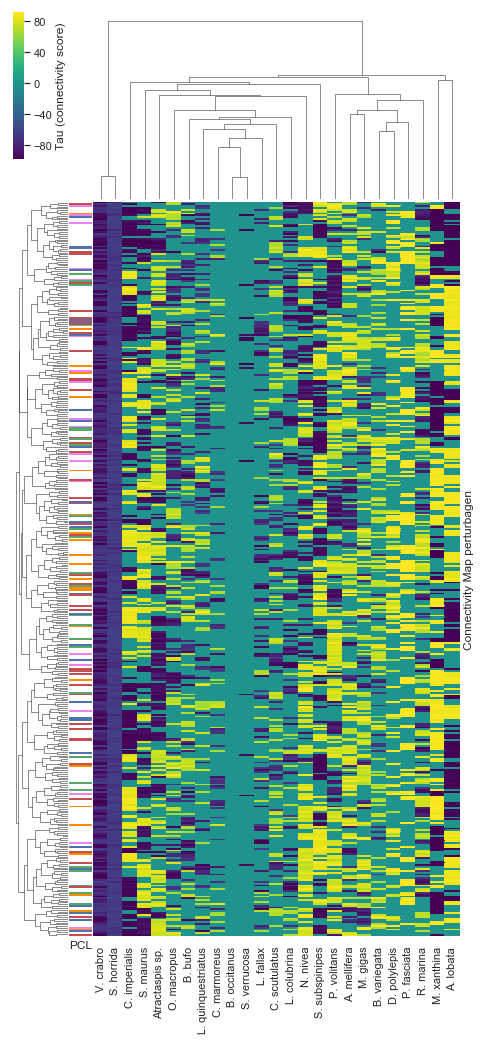

In [192]:
(X, annot) = v.pcl_signatures_with_annotations(type='tau', top_n_metric='var', top_n=400, cell_line='A375')

tmp = v.pcls_from_annotations(annot)
#Counter(list(itertools.chain.from_iterable(tmp))).most_common()
row_labels = pd.Series([x[0] for x in tmp])
lut = {
    "CP_HDAC_INHIBITOR": "r",
    "CP_AURORA_KINASE_INHIBITOR": "b",
    "CP_GLUCOCORTICOID_RECEPTOR_AGONIST": "g",
    "CP_DOPAMINE_RECEPTOR_ANTAGONIST": "darkorange",
    "CP_ESTROGEN_RECEPTOR_AGONIST": "violet"
}
colors_r = row_labels.map(lut)
colors_r = colors_r.fillna("w")

row_linkage = sp.cluster.hierarchy.linkage(X, metric='cosine', method='complete', optimal_ordering=True)
col_linkage = sp.cluster.hierarchy.linkage(X.T, metric='euclidean', method='ward', optimal_ordering=True)

g = sns.clustermap(X, cmap="viridis", robust=True, row_linkage=row_linkage,
                   col_linkage=col_linkage, row_colors=list(colors_r), figsize=(8,17))
g.ax_heatmap.get_yaxis().set_ticks([])
#g.ax_heatmap.set_xlabel("Venom")
g.ax_heatmap.set_ylabel("Connectivity Map perturbagen")
# Label PCL column
g.ax_row_colors.set_xlabel("PCL")
# Label legend
g.cax.set_ylabel("Tau (connectivity score)")
# Change x labels to species

ordered_ven_idxs = [int(x._text) for x in g.ax_heatmap.get_xmajorticklabels()]
new_xticklabels = []
for ovi in ordered_ven_idxs:
    new_xticklabels.append(species_names[ovi])
g.ax_heatmap.get_xaxis().set_ticklabels(new_xticklabels, rotation="vertical")

g.savefig("tau_heatmap.pdf", bbox_inches='tight')

Notice that although we see clearly distinguishable clustering by venom (e.g., column clustering), the clusters by CMap perturbagens are less distinct. We expect this--there are too few venoms to show reliable row clustering for data with such complex correlation structure. Additionally, the clustering of PCLs (plotted between the row dendrogram and the heatmap) are inconsistent for many of the top PCLs in the dataset. This can be accounted for partially by the vast diversity of functional applications of members of the same PCL: for example, Histone Deacetylase Inhibitors can be assigned into at least 11 groups based on the type of HDAC they bind to.

- - -
### Heatmap of PCL wcs's

Several more examples are shown below. Notice that we can obtain similar venom clustering results from both the normalized and unnormalized data (and, importantly, other subsets of the WCS and tau scores), indicating that they are robust.

[Text(0.5,0,'V. crabro'),
 Text(1.5,0,'S. horrida'),
 Text(2.5,0,'M. xanthina'),
 Text(3.5,0,'S. subspinipes'),
 Text(4.5,0,'A. lobata'),
 Text(5.5,0,'C. imperialis'),
 Text(6.5,0,'O. macropus'),
 Text(7.5,0,'L. fallax'),
 Text(8.5,0,'L. colubrina'),
 Text(9.5,0,'S. verrucosa'),
 Text(10.5,0,'B. occitanus'),
 Text(11.5,0,'C. marmoreus'),
 Text(12.5,0,'L. quinquestriatus'),
 Text(13.5,0,'B. bufo'),
 Text(14.5,0,'Atractaspis sp.'),
 Text(15.5,0,'S. maurus'),
 Text(16.5,0,'P. fasciata'),
 Text(17.5,0,'R. marina'),
 Text(18.5,0,'C. scutulatus'),
 Text(19.5,0,'B. variegata'),
 Text(20.5,0,'D. polylepis'),
 Text(21.5,0,'M. gigas'),
 Text(22.5,0,'N. nivea'),
 Text(23.5,0,'A. mellifera'),
 Text(24.5,0,'P. volitans')]

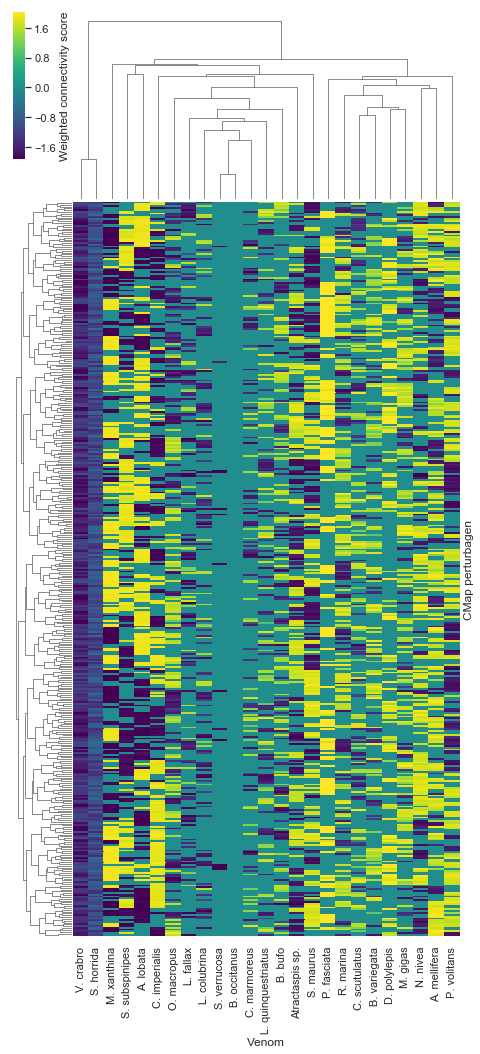

In [122]:
(X2, annot2) = v.pcl_signatures_with_annotations(type='wcs', top_n_metric='var', top_n=400, cell_line='HA1E')

row_linkage = sp.cluster.hierarchy.linkage(X2, metric='cosine', method='complete', optimal_ordering=True)
col_linkage = sp.cluster.hierarchy.linkage(X2.T, metric='euclidean', method='ward', optimal_ordering=True)

g = sns.clustermap(X2, cmap="viridis", robust=True,
                   row_linkage=row_linkage, col_linkage=col_linkage, figsize=(8,17))
g.ax_heatmap.get_yaxis().set_ticks([])
g.ax_heatmap.set_xlabel("Venom")
g.ax_heatmap.set_ylabel("CMap perturbagen")

# Label PCL column
#g.ax_row_colors.set_xlabel("PCL", rotation="vertical")

# Label legend
g.cax.set_ylabel("Weighted connectivity score")

ordered_ven_idxs = [int(x._text) for x in g.ax_heatmap.get_xmajorticklabels()]
new_xticklabels = []
for ovi in ordered_ven_idxs:
    new_xticklabels.append(species_names[ovi])
g.ax_heatmap.get_xaxis().set_ticklabels(new_xticklabels, rotation="vertical")

[Text(0.5,0,'V. crabro'),
 Text(1.5,0,'S. horrida'),
 Text(2.5,0,'M. xanthina'),
 Text(3.5,0,'A. lobata'),
 Text(4.5,0,'S. subspinipes'),
 Text(5.5,0,'N. nivea'),
 Text(6.5,0,'B. bufo'),
 Text(7.5,0,'L. quinquestriatus'),
 Text(8.5,0,'S. verrucosa'),
 Text(9.5,0,'B. occitanus'),
 Text(10.5,0,'C. marmoreus'),
 Text(11.5,0,'L. fallax'),
 Text(12.5,0,'L. colubrina'),
 Text(13.5,0,'O. macropus'),
 Text(14.5,0,'Atractaspis sp.'),
 Text(15.5,0,'P. volitans'),
 Text(16.5,0,'S. maurus'),
 Text(17.5,0,'C. imperialis'),
 Text(18.5,0,'R. marina'),
 Text(19.5,0,'C. scutulatus'),
 Text(20.5,0,'B. variegata'),
 Text(21.5,0,'M. gigas'),
 Text(22.5,0,'D. polylepis'),
 Text(23.5,0,'P. fasciata'),
 Text(24.5,0,'A. mellifera')]

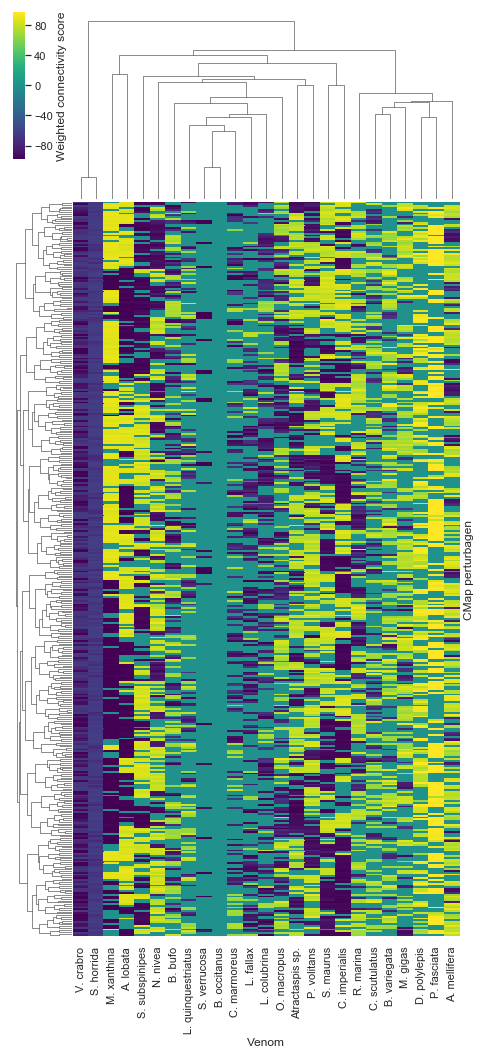

In [123]:
X3 = v.subset_connectivity_data(type='tau', top_n_metric='var', top_n=400, cell_line='HA1E')

row_linkage = sp.cluster.hierarchy.linkage(X3, metric='cosine', method='complete', optimal_ordering=True)
col_linkage = sp.cluster.hierarchy.linkage(X3.T, metric='euclidean', method='ward', optimal_ordering=True)

g = sns.clustermap(X3, cmap="viridis", robust=True,
                   row_linkage=row_linkage, col_linkage=col_linkage, figsize=(8,17))
g.ax_heatmap.get_yaxis().set_ticks([])
g.ax_heatmap.set_xlabel("Venom")
g.ax_heatmap.set_ylabel("CMap perturbagen")

# Label PCL column
#g.ax_row_colors.set_xlabel("PCL", rotation="vertical")

# Label legend
g.cax.set_ylabel("Weighted connectivity score")

ordered_ven_idxs = [int(x._text) for x in g.ax_heatmap.get_xmajorticklabels()]
new_xticklabels = []
for ovi in ordered_ven_idxs:
    new_xticklabels.append(species_names[ovi])
g.ax_heatmap.get_xaxis().set_ticklabels(new_xticklabels, rotation="vertical")

- - -
### PCA plot on venom connectivities
These illustrate venom outliers - things that are highly negative or highly positive on the heatmaps are labeled on the PCA plot.

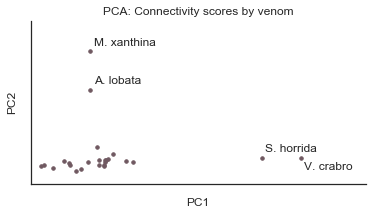

In [190]:
sns.set_style('white')

pca = PCA()
X_r = pca.fit(v.connectivity.tau.T).transform(v.connectivity.tau.T)
(fig, ax) = plt.subplots(1, 1, figsize=(6,3))

ax.scatter(X_r[:,0], X_r[:,1], s=12, c='#705961')
ax.set_ylim(-10000,45000)
ax.set_xlim(-20000,70000)

ax.set(xticklabels=[])
ax.set(yticklabels=[])

sns.despine()

ax.set(xlabel='PC1')
ax.set(ylabel='PC2')
ax.set(title='PCA: Connectivity scores by venom')
for label, x, y, in zip(np.take(species_names,[2,9,11,19]),
                        np.take(X_r[:,0],[2,9,11,19]),
                        np.take(X_r[:,1],[2,9,11,19])
                       ):
    if label=='V. crabro':
        ax.annotate(label, xy=(x+1000,y-4000))
    else:
        ax.annotate(label, xy=(x+1000, y+2000))
        
fig.savefig("pca.pdf", bbox_inches='tight')

[2.13389713e-01 6.91074317e-02 6.28040720e-02 6.15980137e-02
 5.85979565e-02 5.29648708e-02 4.83975854e-02 4.71317775e-02
 4.54511813e-02 4.07311300e-02 3.78000110e-02 3.54758169e-02
 3.18473672e-02 2.87610370e-02 2.68344287e-02 2.54000133e-02
 2.38550064e-02 2.32582834e-02 2.22835950e-02 2.03882071e-02
 1.66296882e-02 5.25909492e-03 1.22661116e-03 8.07108207e-04
 3.77073175e-30]


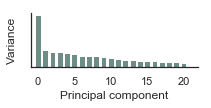

In [193]:
# Explained variance plot
ev = pca.explained_variance_ratio_
print(ev)
(fig, ax) = plt.subplots(1,1, figsize=(3,1))

ax.bar(range(len(ev)), ev, color='#6D8E87')
sns.despine()
ax.set_xlim(-1,22)
ax.set(yticklabels=[])
ax.set(xlabel='Principal component')
ax.set(ylabel='Variance')

fig.savefig("explained_var.pdf", bbox_inches='tight')